### Imports

In [1]:
from sklearn.model_selection import train_test_split
from random import shuffle
import skimage.transform as transform
import csv
import cv2
import numpy as np
import sklearn
import math

# Keras
import matplotlib.pyplot as plt
from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.layers import Dense, Flatten, Lambda, MaxPool2D, Dropout,Cropping2D, Convolution2D
from keras.optimizers import Adam

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


### Load data


In [2]:
samples = []
with open("./data/driving_log.csv") as csvFile:
    csvReder = csv.reader(csvFile)
    for line in  csvReder:
        samples.append(line)

# Split traning data
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

### Generator

Create generator to preprocess data

In [8]:
def process_image(filename, angle):
    pass

# generator
def samples_generator(samples, batch_size=32):
    # Get total number of samples
    num_samples = len(samples)

    while True:
        shuffle(samples)
        for offset in range(0,batch_size, num_samples):
            # CSV data center,left,right,steering,throttle,brake,speed
            # Get batch
            batch_samples = samples[offset:offset+batch_size]
            # Process each image in the batch
            images = []
            angles = []
            for batch_sample in batch_samples:
                center_image = cv2.imread("./data/IMG/"+batch_sample[0].split("/")[-1])
                left_image   = cv2.imread("./data/IMG/"+batch_sample[1].split("/")[-1])
                right_image  = cv2.imread("./data/IMG/"+batch_sample[2].split("/")[-1])

                #center_image = transform.resize(center_image, (66,200))

                correction   = 0.2
                center_angle = float(batch_sample[3])
                left_angle   = center_angle + correction
                right_angle  = center_angle - correction
                images.extend([center_image,left_image,right_image])
                angles.extend([center_angle, left_angle, right_angle])

                #center_image_flipped = np.fliplr(center_image)
                #center_angle_flipped = -center_angle
                #images.append(center_angle_flipped)
                #angles.append(center_angle_flipped)

            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

#### Create traning anf validation


In [10]:
train_generator = samples_generator(train_samples, batch_size=32)
validation_generator = samples_generator(validation_samples, batch_size=32)

### Build model

In [6]:
opt = Adam(lr=0.0001)

model = Sequential()
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((50,20), (0,0))))
model.add(Convolution2D(24, kernel_size=(5,5), strides=(2, 2), padding='valid', activation="relu"))
model.add(Convolution2D(36, kernel_size=(5,5), strides=(2, 2), padding='valid', activation="relu"))
model.add(Convolution2D(48, kernel_size=(5,5), strides=(2, 2), padding='valid', activation="relu"))
model.add(Convolution2D(64, kernel_size=(3,3), strides=(1, 1), padding='valid', activation="relu"))
model.add(Convolution2D(64, kernel_size=(3,3), strides=(1, 1), padding='valid', activation="relu"))
model.add(Flatten())
model.add(Dense(1164,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(100,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(50,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(10, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss="mse", optimizer=opt)
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_1 (Cropping2D)    (None, 90, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 43, 158, 24)       1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 77, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 37, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 35, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 33, 64)         36928     
__________

### Train

In [11]:
batch_size       = 32
steps_per_epoch  = math.ceil(len(train_samples * 3)/batch_size)
validation_steps = math.ceil(len(validation_samples *3)/32)

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=steps_per_epoch, 
    validation_data=validation_generator,
    validation_steps=validation_steps, 
    epochs=5,
    verbose=1).history

Epoch 1/5
 36/603 [>.............................] - ETA: 760s - loss: 0.0305

KeyboardInterrupt: 

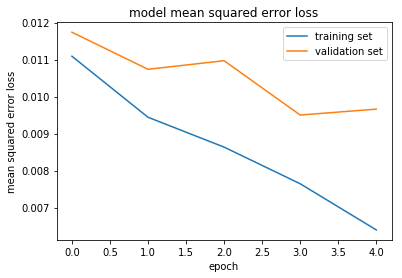

In [7]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

model.save("model.h5")
